# Exploratory Data Analysis

## Dataset File Structure and Class Proportions

FIrst I will investigate the file structure of the dataset. Below I do so by printing out the directory tree for the dataset.

In [1]:
import os

# Define a funtion that prints out the tree for a given directory,
# showing only subdirectories and file counts

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}-{}'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        filecount = len(files)
        if filecount>0:
            print(f'{subindent}-{filecount} files')

list_files('../data/FLAME_Dataset_subset')

-FLAME_Dataset_subset
    -Test
        -Fire
            -353 files
        -No_Fire
            -211 files
    -Training
        -Fire
            -1574 files
        -No_Fire
            -889 files


As per the above, the dataset is split into Test and Training directories, each of which are further subdivided into Fire and No_Fire classed images. Examining the file counts clearly shows that there is a significant class imbalance between Fire and Non-Fire images, and that the Fire Class is overrepresented in the training set relative to the Test set. This may have an adverse impact on test specificity later on, as it may influence the CNN to class images as Fire (positive) less often

## Dataset Pixel Size

Next, I will plot the pizel sizes of all of the images in the dataset in $\mathbb{R}^2$

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define a function that returns the pixel dimensions of an image as a list
def get_dims(im_path):
    im = Image.open(im_path)
    arr = np.array(im)
    h,w,c = arr.shape
    return [h,w]

get_dims('../data/FLAME_Dataset_subset/Training/Fire/resized_frame20129.jpg')

[254, 254]

In [8]:
# Loop through the entire dataset

height = []
width = []
train_test_flag = []
fire_flag = []

root_path = '../data/FLAME_Dataset_subset'

for s in ['Test','Training']:
    for c in ['Fire','No_Fire']:
        current_dir = os.path.join(root_path,s,c)
        file_seq = os.scandir(current_dir)
        for item in file_seq:
            train_test_flag.append(s)
            fire_flag.append(c)
            img_dims = get_dims(item.path)
            height.append(img_dims[0])
            width.append(img_dims[1])

# Summarise in dataframe
import pandas as pd
image_dim_df = pd.DataFrame(
    data = {
        'height':height,
        'width':width,
        'train_test':train_test_flag,
        'fire_noFire':fire_flag
    }
)


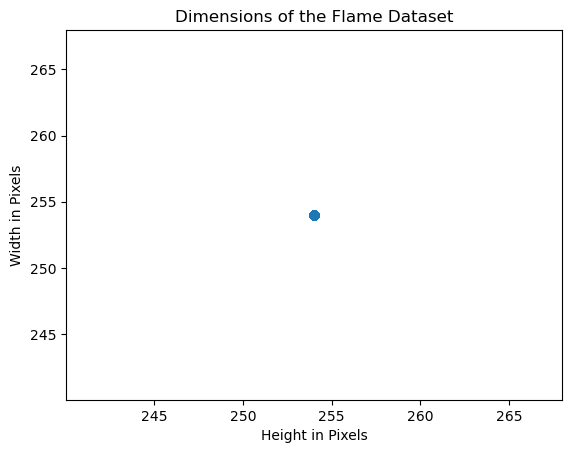

In [10]:
# Visualize the result
plt.scatter(image_dim_df['height'],image_dim_df['width'])
plt.xlabel('Height in Pixels')
plt.ylabel('Width in Pixels')
plt.title('Dimensions of the Flame Dataset')
plt.savefig('../figures/flame_dataset_image_dimensions.png')
plt.show()

In [14]:
# Test if there are any images that are not 255 X 255

((image_dim_df.height != 254) & (image_dim_df.width != 254)).any()

False